<a href="https://colab.research.google.com/github/MurphLaws/Exp/blob/main/GroupExperiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

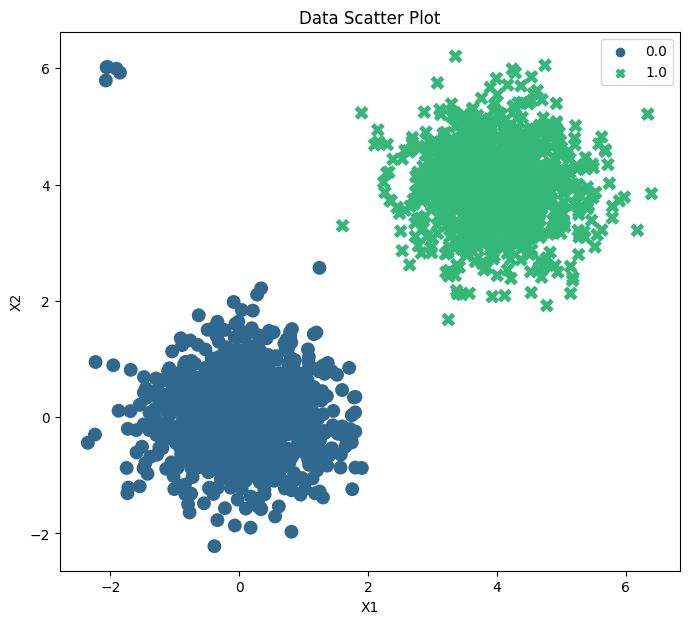

100%|██████████| 1/1 [00:00<00:00, 12.20it/s]


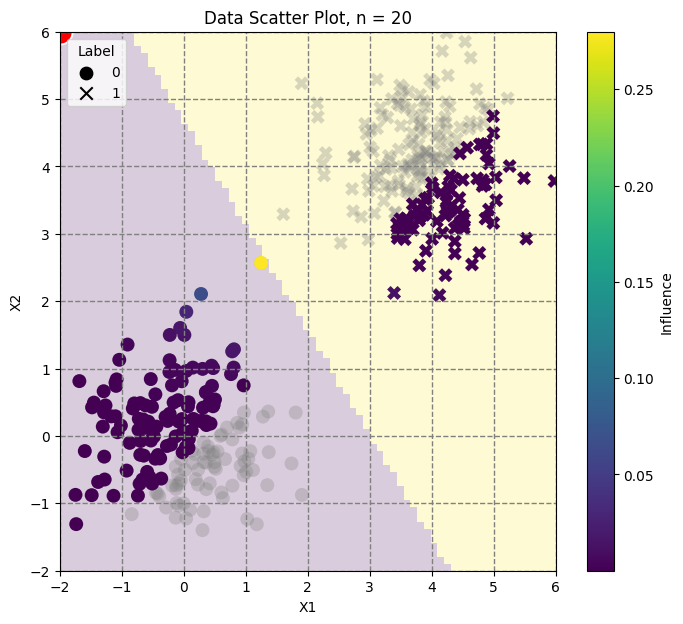

In [521]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from collections import namedtuple
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import DecisionBoundaryDisplay
from tqdm import tqdm
import seaborn as sns
import math

class Dataset:

    def __init__(self, train = pd.DataFrame(), test = pd.DataFrame(), df = None):
        self.train = train
        self.test = test
        self.df = pd.concat([train,test]).sort_index()


    def populate(self, cluster_number,n,df=None):
        random.seed(2349324)
        np.random.seed(2349324)
        tf.random.set_seed(2349324)

        if cluster_number == 2:
            covmat = [[0.5, 0], [0, 0.5]]
            mean_1 = [0,0]
            class1_x1, class1_x2 = np.random.multivariate_normal(mean_1, covmat, int(n/2)).T

            mean_2 = [4,4]
            class2_x1, class2_x2 = np.random.multivariate_normal(mean_2, covmat, int(n/2)).T

            part1 = list(zip(class1_x1, class1_x2,itertools.repeat(0)))
            part2 = list(zip(class2_x1, class2_x2,itertools.repeat(1)))

            self.df = pd.DataFrame(np.concatenate((part1,part2),axis=0), columns = ["X1", "X2", "Label"])

        if cluster_number == 3:
            covmat = [[0.5, 0], [0, 0.5]]


            len1 = int(n/3)
            len2 = int(n/3)
            len3 = n-len1-len2

            mean_1 = [0,0]
            class1_x1, class1_x2 = np.random.multivariate_normal(mean_1, covmat, len1).T

            mean_2 = [4,0]
            class2_x1, class2_x2 = np.random.multivariate_normal(mean_2, covmat, len2).T

            mean_3 = [2,2*math.sqrt(3)]
            class3_x1, class3_x2 = np.random.multivariate_normal(mean_3, covmat, len3).T

            part1 = list(zip(class1_x1, class1_x2,itertools.repeat(0)))
            part2 = list(zip(class2_x1, class2_x2,itertools.repeat(2)))
            part3 = list(zip(class3_x1, class3_x2,itertools.repeat(1)))

            self.df = pd.DataFrame(np.concatenate((part1,part2,part3),axis=0), columns = ["X1", "X2", "Label"])
        self.train = self.df.sample(frac=0.8, random_state=1).copy()
        self.test = self.df.drop(self.train.index).copy()

    def get_all_data(self):
        return self.df

    def plot_data(self):
        plt.figure(figsize=(8,7))


        sns.scatterplot(data=self.df, x='X1', y='X2', hue='Label', palette='viridis', style='Label',s=100, linewidth=0)
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.legend()
        plt.title("Data Scatter Plot")

        plt.show()

    def train_predict(self, output = 'loss'):

        x_train = self.train[['X1','X2']]
        y_train = self.train['Label']

        x_test  = self.test[['X1','X2']]
        y_test  = self.test['Label']

        np.random.seed(2349324)
        fan_avg = (x_train.shape[1] + 1) / 2  # Average of input and output dimensions
        limit = np.sqrt(6 / fan_avg)
        weights_init = np.random.uniform(low=-limit, high=limit, size=(x_train.shape[1],))

        logreg = LogisticRegression(solver='liblinear', random_state=2349324)
        logreg.coef_ = weights_init.reshape(1, -1)

        logreg.fit(x_train, y_train)

        y_pred  = logreg.predict(x_test)
        y_proba = logreg.predict_proba(x_test)

        if output == 'loss':
            return np.array(Dataset.binary_cross_entropy(list(y_test), y_proba))
        elif output == 'boundary':
            return logreg
        elif output == 'proba':
            return y_pred, y_proba

    def plot_boundary(self):
        _, ax = plt.subplots(figsize=(8, 7))
        DecisionBoundaryDisplay.from_estimator(
            self.train_predict(output='boundary'),
            self.train[['X1','X2']],
            ax=ax,
            response_method="predict",
            plot_method="pcolormesh",
            xlabel="X1",
            ylabel="X2",
            alpha = 0.3
        )

        sns.scatterplot(data=self.train, x='X1', y='X2', hue='Label', palette='viridis', style='Label',s=100, linewidth=0)
        plt.title('Logistic Regression Boundary')
        plt.show()

    def loo(self,groups):
        datasets = []
        for group in groups:
            datasets.append((group,Dataset(self.train.drop(group),self.test)))
        return datasets

    @staticmethod
    def binary_cross_entropy(predictions, probabilities):
        binary_crossentropy = []
        for i in range(len(predictions)):
            b = predictions[i]
            p = probabilities[i][1]  # Assuming the probability of the positive class is at index 1

            # Calculate the binary crossentropy
            cross_entropy = -b * np.log(p) - (1 - b) * np.log(1 - p)
            binary_crossentropy.append(cross_entropy)

        return binary_crossentropy



    def get_inf_matrix(self, groups):
        datasets = self.loo(groups)
        inf_matrix = pd.DataFrame(columns=list(datasets[0][1].test.index))#0, index=groups, columns=list(datasets[0][1].test.index))

        for ds in tqdm(datasets):
            inf_matrix.loc[str(ds[0])] = ds[1].train_predict()-self.train_predict()
        return inf_matrix


    def contaminate(self,position,n,label):
        cov = [[0.01,0],[0,0.01]]
        x1, x2= np.random.multivariate_normal(position, cov, n).T

        final_index = self.df.index.max()
        result = pd.DataFrame(list(zip(x1, x2,itertools.repeat(label))), columns = ["X1", "X2", "Label"])
        reindexed_result = result.set_index(pd.RangeIndex(start=final_index + 1, stop=final_index + 1 + len(result)))
        return (position, list(reindexed_result.index),Dataset(train=pd.concat([self.train.copy(),reindexed_result]),test=self.test))


    def visualize_influence(self, matrix, sign,center,original):
        #test_df = self.test.loc[list(matrix.columns)].lt(0)



        group = self.train.loc[eval(list(matrix.index)[0])]

        if sign == "negative":
            test_points = self.test.loc[list(matrix.where(matrix.lt(0)).dropna(axis=1).columns)].copy()
            test_points["Influence"]=matrix.where(matrix.lt(0)).dropna(axis=1).values.T

        if sign == "positive":
            test_points = self.test.loc[list(matrix.where(matrix.gt(0)).dropna(axis=1).columns)].copy()
            test_points["Influence"]=matrix.where(matrix.gt(0)).dropna(axis=1).values.T

        if sign == 'all':
            test_points = self.test.loc[list(matrix.columns)].copy()
            test_points["Influence"]=matrix.values.T


        _, ax = plt.subplots(figsize=(8, 7))
        DecisionBoundaryDisplay.from_estimator(
        self.train_predict(output='boundary'),
        self.train[['X1','X2']],
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        xlabel="X1",
        ylabel="X2",
        alpha = 0.2
        )


        marker_map = {1:'X',0:'o',2:'s'}
        center_df = pd.DataFrame({'x': [center[0]], 'y': [center[1]]})

        sns.scatterplot(data=self.test, x='X1', y='X2',color='gray', style='Label',s=100, linewidth=0,alpha=0.3)
        sp = sns.scatterplot(data=test_points, x='X1', y='X2', hue='Influence', palette='viridis', style='Label',s=100, linewidth=0, markers = {1:'X',0:'o',2:'s'})
        sns.scatterplot(data=center_df, x='x', y='y',marker=marker_map[list(group['Label'])[0]], color='red', s=300)
        #plt.scatter(group['X1'], group['X2'], s=100, c="black",linewidths=1,edgecolors='black')
        plt.xlabel('X1')
        plt.ylabel('X2')


        custom_handles = [
        plt.scatter([], [], marker='o', s=80, color='black', label='0'),
        plt.scatter([], [], marker='x', s=80, color='black', label='1'),
        ]

        norm = plt.Normalize(test_points['Influence'].min(), test_points['Influence'].max())
        sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
        sp.figure.colorbar(sm, ax=sp).set_label('Influence')

        plt.legend(handles=custom_handles, title='Label')
        plt.title("Data Scatter Plot, n = 20")
        plt.xlim(-2,6)
        plt.ylim(-2,6)
        plt.grid(True, linewidth=1, linestyle='--', color='gray')
        plt.show()

        #return #list(group['Label'])[0]




#means = [[0,0],[-1,0],[1,0]]
# matrixes = []
# for i in means:
#     indexes,ds = no_1.contaminate(i,10,1)
#     matrixes.append((ds.get_inf_matrix([indexes])))

# matrixes



no_1 = Dataset()
no_1.populate(2, 2000)


center, contaminated_group, contaminated_data = no_1.contaminate([-2,6],5,0)
contaminated_data.plot_data()
matrix_1 = contaminated_data.get_inf_matrix([contaminated_group])
contaminated_data.visualize_influence(matrix_1, "positive",center, no_1)



''